In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import sys, os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
tf.__version__

'2.2.0'

In [3]:
%matplotlib inline

In [4]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Data Generator

In [5]:
train_data_dir = '../data/CollisionData/'

img_width, img_height = 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 10
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data

Found 730 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


### Model Architecture
MobileNet V1 Base

Using imagenet weights as initialization. The entire architecture is retrainable.

In [7]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True #change this to False is retraining is not to be done in base layers

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(1, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

base_model = MobileNet(weights='imagenet', 
                      include_top=False, 
                      input_shape=input_shape)

class_list = ['CollisionOrClose', 'NoCollision']
FC_LAYERS = [256, 256]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [8]:
adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "MobileNetV1" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

In [9]:
finetune_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

### Model Size

In [12]:
shapes_count = int(np.sum([np.prod(np.array([s if isinstance(s, int) else 1 for s in l.output_shape])) for l in finetune_model.layers]))
memory = shapes_count * 4

print ("Model Size(mb): %d" % (memory/1000000))

Model Size(mb): 67


In [11]:
trainable_count = np.sum([K.count_params(w) for w in finetune_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in finetune_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 16,140,225
Trainable params: 16,118,337
Non-trainable params: 21,888


### Training and Testing

In [13]:
history = finetune_model.fit_generator(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True,) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
45/45 [==============================] - 16s 351ms/step - loss: 0.9170 - accuracy: 0.7213 - val_loss: 0.4882 - val_accuracy: 0.7841
Epoch 2/10
45/45 [==============================] - 15s 339ms/step - loss: 0.5381 - accuracy: 0.7955 - val_loss: 0.3164 - val_accuracy: 0.8409
Epoch 3/10
45/45 [==============================] - 15s 342ms/step - loss: 0.5090 - accuracy: 0.8069 - val_loss: 0.2904 - val_accuracy: 0.8636
Epoch 4/10
45/45 [==============================] - 15s 336ms/step - loss: 0.4049 - accuracy: 0.8361 - val_loss: 0.2291 - val_accuracy: 0.8864
Epoch 5/10
45/45 [==============================] - 15s 335ms/step - loss: 0.3884 - accuracy: 0.8501 - val_loss: 0.1943 - val_accuracy: 0.9148
Epoch 6/10
45/45 [==============================] - 15s 337ms/step - loss: 0.3298 - accuracy: 0.8627 - val_loss: 0.2221 - val_accuracy: 0.9148
Epoch 7/10
45/45 [==============================] - 15s 338ms/step

### Performance

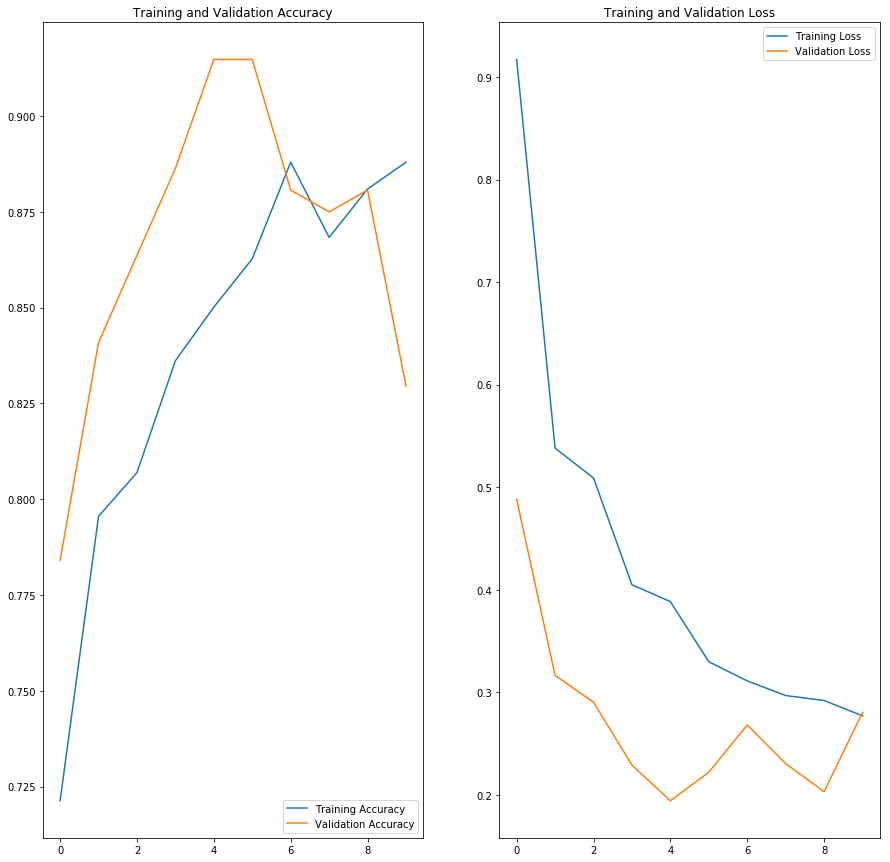

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix


probabilities = finetune_model.predict_generator(generator=validation_generator)
print(probabilities)

Instructions for updating:
Please use Model.predict, which supports generators.
[[0.03810709]
 [0.04772145]
 [0.7287559 ]
 [0.04161218]
 [0.01966427]
 [0.12871811]
 [0.04807961]
 [0.04155701]
 [0.11064223]
 [0.14858273]
 [0.06709319]
 [0.09493267]
 [0.15875998]
 [0.01929321]
 [0.0606078 ]
 [0.03747372]
 [0.07101569]
 [0.01982132]
 [0.03053708]
 [0.49535686]
 [0.01987488]
 [0.02236435]
 [0.07330336]
 [0.03212777]
 [0.26483825]
 [0.02783179]
 [0.01563603]
 [0.02912439]
 [0.6122205 ]
 [0.33770084]
 [0.04832989]
 [0.5927688 ]
 [0.08580695]
 [0.41902864]
 [0.02004744]
 [0.02892522]
 [0.01741707]
 [0.03501753]
 [0.02779967]
 [0.02150227]
 [0.08059555]
 [0.994759  ]
 [0.98820007]
 [0.978224  ]
 [0.9982551 ]
 [0.98455274]
 [0.96807253]
 [0.98644686]
 [0.9879775 ]
 [0.98054117]
 [0.9683147 ]
 [0.9860212 ]
 [0.9857266 ]
 [0.9828463 ]
 [0.9956923 ]
 [0.99782974]
 [0.99226135]
 [0.9632146 ]
 [0.9966545 ]
 [0.98573154]
 [0.9869006 ]
 [0.9915039 ]
 [0.9902873 ]
 [0.97578967]
 [0.9810619 ]
 [0.873016

In [18]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys())  

In [19]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

                  precision    recall  f1-score   support

CollisionOrClose       0.66      0.93      0.77        41
     NoCollision       0.98      0.86      0.91       140

        accuracy                           0.87       181
       macro avg       0.82      0.89      0.84       181
    weighted avg       0.90      0.87      0.88       181



In [21]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[ 38   3]
 [ 20 120]]


### Analyze Results

In [22]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

In [ ]:
labels = (validation_generator.class_indices)

In [ ]:
labels